## Extension: BERTopic 

This jupyter file follows as we attempt to do a comparative analysis between STM and a modern framework, namely BERTopic. 

In [46]:
import pandas as pd
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
DATA_DIR = "/Users/giomhern/04 Projects/topic-models/data"
df = pd.read_csv(f"{DATA_DIR}/gadarian_bertopic_input.csv")
texts = df["open.ended.response"].astype(str).tolist()

In [153]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")
kmeans_model = KMeans(n_clusters=3, random_state=42)
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model = kmeans_model, 
    calculate_probabilities=False,
    verbose=True
)

In [160]:
topics, _ = topic_model.fit_transform(texts)

# Show top 15 words for each topic
for topic_idx in topic_model.get_topics().keys():
    print(f"\n--- Topic {topic_idx} ---")
    for word, weight in topic_model.get_topic(topic_idx)[:15]:
        print(f"{word:<15} {weight:.5f}")

2025-05-29 03:52:29,207 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 11/11 [00:00<00:00, 53.28it/s]
2025-05-29 03:52:29,418 - BERTopic - Embedding - Completed ✓
2025-05-29 03:52:29,418 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-29 03:52:29,697 - BERTopic - Dimensionality - Completed ✓
2025-05-29 03:52:29,698 - BERTopic - Cluster - Start clustering the reduced embeddings
/opt/anaconda3/envs/models/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/models/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/models/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

2025-05-29 03:52:29,700 - BERTopic - Cluster - Completed ✓
2025-05-29 03:52:29,701 - BERTopic - Representation - Fine-tuning 


--- Topic 0 ---
jobs            0.10629
people          0.06557
illegal         0.06493
americans       0.06314
welfare         0.06115
care            0.05780
taxes           0.04862
security        0.04679
social          0.04641
immigrants      0.04515

--- Topic 1 ---
illegal         0.10536
people          0.09744
immigrants      0.08177
country         0.07615
mexico          0.06034
border          0.05925
coming          0.05522
legal           0.04923
entering        0.04482
english         0.03863

--- Topic 2 ---
immigration     0.09282
think           0.09010
immigrants      0.07798
people          0.06006
country         0.05926
need            0.05137
legally         0.04147
illegal         0.04138
worry           0.04075
come            0.03783


In [162]:
df["topic"] = topics

topic_labels = {
    0: "Economic Costs",
    1: "Border Control",
    2: "Moral Reasoning"
}
df["topic_label"] = df["topic"].map(topic_labels)

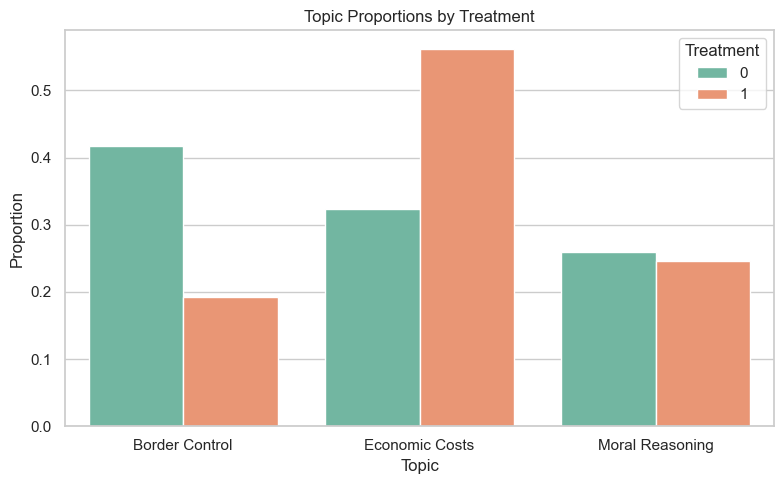

In [163]:
topic_counts = df.groupby(["treatment", "topic_label"]).size().reset_index(name="count")
topic_counts["proportion"] = topic_counts.groupby("treatment")["count"].transform(lambda x: x / x.sum())

plt.figure(figsize=(8, 5))
sns.barplot(data=topic_counts, x="topic_label", y="proportion", hue="treatment", palette="Set2")
plt.title("Topic Proportions by Treatment")
plt.ylabel("Proportion")
plt.xlabel("Topic")
plt.legend(title="Treatment")
plt.tight_layout()
plt.show()

In [174]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Setup: classify Topic 1
df["is_topic_1"] = (df["topic"] == 0).astype(int)  # Adjust if needed

# Center pid_rep
df["pid_centered"] = df["pid_rep"] - df["pid_rep"].mean()
df["interaction"] = df["pid_centered"] * df["treatment"]

# Fit logistic model with interaction
X = sm.add_constant(df[["treatment", "pid_centered", "interaction"]])
y = df["is_topic_1"]
model = sm.Logit(y, X).fit(disp=0)

# Prediction grid
pid_vals = np.linspace(df["pid_rep"].min(), df["pid_rep"].max(), 100)
grid = []
for t in [0, 1]:
    for pid in pid_vals:
        centered = pid - df["pid_rep"].mean()
        grid.append({
            "const": 1,
            "treatment": t,
            "pid_centered": centered,
            "interaction": centered * t,
            "pid_rep": pid,
            "label": "Treated" if t == 1 else "Control"
        })

pred_df = pd.DataFrame(grid)
pred_X = pred_df[["const", "treatment", "pid_centered", "interaction"]]

# Predict with confidence intervals
pred = model.get_prediction(pred_X).summary_frame(alpha=0.05)
pred_df["predicted"] = pred["predicted"]
pred_df["lower"] = pred["ci_lower"]
pred_df["upper"] = pred["ci_upper"]

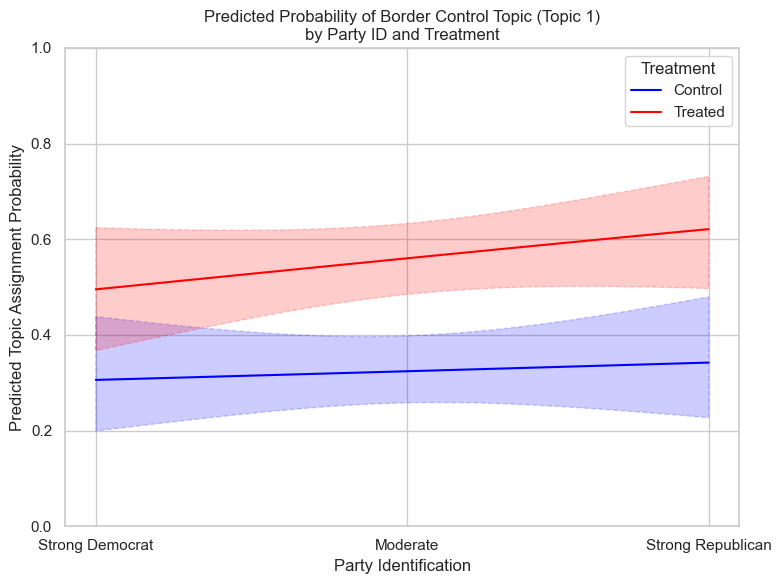

In [175]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Plot fitted lines and confidence bands
for label, color in zip(["Control", "Treated"], ["blue", "red"]):
    subset = pred_df[pred_df["label"] == label]
    plt.plot(subset["pid_rep"], subset["predicted"], label=label, color=color)
    plt.fill_between(subset["pid_rep"], subset["lower"], subset["upper"], color=color, alpha=0.2, linestyle="dashed")

# Axis labels & ticks to match STM style
plt.xticks([df["pid_rep"].min(), df["pid_rep"].mean(), df["pid_rep"].max()],
           labels=["Strong Democrat", "Moderate", "Strong Republican"])
plt.title("Predicted Probability of Border Control Topic (Topic 1)\nby Party ID and Treatment")
plt.xlabel("Party Identification")
plt.ylabel("Predicted Topic Assignment Probability")
plt.ylim(0, 1)
plt.legend(title="Treatment")
plt.tight_layout()
plt.show()

In [179]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Filter to just Topic 0 and Topic 2
selected_topics = [0, 2]
results = []

for topic_id in selected_topics:
    df["is_topic"] = (df["topic"] == topic_id).astype(int)

    X = sm.add_constant(df["treatment"])
    y = df["is_topic"]
    model = sm.OLS(y, X).fit()
    
    coef = model.params["treatment"]
    ci = model.conf_int().loc["treatment"]

    results.append({
        "Topic": f"Topic {topic_id}",
        "Effect": coef,
        "CI_lower": ci[0],
        "CI_upper": ci[1]
    })

effects_df = pd.DataFrame(results)

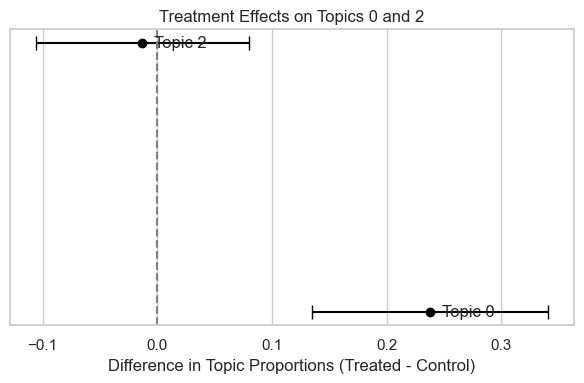

In [182]:
plt.figure(figsize=(6, 4))

for i, row in effects_df.iterrows():
    plt.errorbar(
        x=row["Effect"],
        y=i,
        xerr=[[row["Effect"] - row["CI_lower"]], [row["CI_upper"] - row["Effect"]]],
        fmt='o',
        color='black',
        capsize=5
    )
    plt.text(row["Effect"] + 0.01, i, row["Topic"], va="center")

plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("Difference in Topic Proportions (Treated - Control)")
plt.yticks([])
plt.title("Treatment Effects on Topics 0 and 2")
plt.tight_layout()
plt.show()

## ANES Data 

In [194]:
df = pd.read_csv(f"{DATA_DIR}/final_anes_metadata.csv")
df["text"] = df[["mii_1", "mii_2"]].fillna("").agg(" ".join, axis=1).str.strip()
df = df[
    (df["pid_summary"] > 0) &
    (df["highest grade completed"] > 0) &
    (df["age"] > 0) &
    (df["text"] != "") &
    df["female"].notna()
].copy()

# Extract text and covariates
texts = df["text"].tolist()
covariates = df[["pid_summary", "age", "highest grade completed", "female"]]

In [218]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# Setup components
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")
kmeans_model = KMeans(n_clusters=10, random_state=42)

# Fit BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=kmeans_model,
    calculate_probabilities=False,
    verbose=True
)

topics = topic_model.fit_transform(texts)[0]
df["topic"] = topics

2025-05-29 04:25:58,205 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 47/47 [00:00<00:00, 116.76it/s]
2025-05-29 04:25:58,613 - BERTopic - Embedding - Completed ✓
2025-05-29 04:25:58,614 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-29 04:26:00,597 - BERTopic - Dimensionality - Completed ✓
2025-05-29 04:26:00,598 - BERTopic - Cluster - Start clustering the reduced embeddings
/opt/anaconda3/envs/models/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/models/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/opt/anaconda3/envs/models/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

2025-05-29 04:26:00,601 - BERTopic - Cluster - Completed ✓
2025-05-29 04:26:00,602 - BERTopic - Representation - Fine-tuning

In [219]:
with open("top_bertopic_words.txt", "w") as f:
    for topic_num in topic_model.get_topic_info().head(10)["Topic"]:
        if topic_num == -1:
            continue  # skip outliers
        f.write(f"\n--- Topic {topic_num} ---\n")
        for word, weight in topic_model.get_topic(topic_num)[:15]:
            f.write(f"{word:<15} {weight:.5f}\n")

In [226]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Select topic
target_topic = 5  # adjust as needed
df["is_topic"] = (df["topic"] == target_topic).astype(int)

# Party dummy: 0 = Democrat (pid < 4), 1 = Republican (pid >= 4)
df["is_republican"] = (df["pid_summary"] >= 4).astype(int)

# Center education
df["edu_centered"] = df["highest grade completed"] - df["highest grade completed"].mean()

# Interaction term
df["interaction"] = df["edu_centered"] * df["is_republican"]

In [227]:
X = sm.add_constant(df[["edu_centered", "is_republican", "interaction"]])
y = df["is_topic"]

model = sm.Logit(y, X).fit(disp=0)

In [228]:
# Prediction grid
edu_vals = np.linspace(13, 17, 100)
grid = []

for party in [0, 1]:  # 0 = Democrat, 1 = Republican
    for edu in edu_vals:
        edu_c = edu - df["highest grade completed"].mean()
        grid.append({
            "const": 1,
            "edu_centered": edu_c,
            "is_republican": party,
            "interaction": edu_c * party,
            "education": edu,
            "label": "Republican" if party else "Democrat"
        })

pred_df = pd.DataFrame(grid)
pred_X = pred_df[["const", "edu_centered", "is_republican", "interaction"]]

# Predict with CI
pred = model.get_prediction(pred_X).summary_frame(alpha=0.05)
pred_df["predicted"] = pred["predicted"]
pred_df["lower"] = pred["ci_lower"]
pred_df["upper"] = pred["ci_upper"]

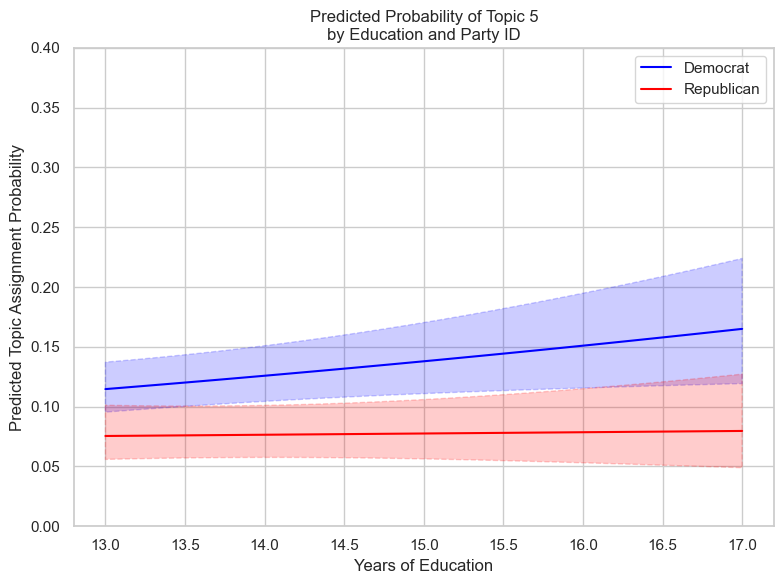

In [230]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

for label, color in zip(["Democrat", "Republican"], ["blue", "red"]):
    subset = pred_df[pred_df["label"] == label]
    plt.plot(subset["education"], subset["predicted"], label=label, color=color)
    plt.fill_between(subset["education"], subset["lower"], subset["upper"], color=color, alpha=0.2, linestyle="dashed")

plt.title(f"Predicted Probability of Topic {target_topic}\nby Education and Party ID")
plt.xlabel("Years of Education")
plt.ylabel("Predicted Topic Assignment Probability")
plt.ylim(0, .4)
plt.legend(title="")
plt.tight_layout()
plt.show()